## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflo

In [4]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [5]:
type(keras.regularizers.l1)

function

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.regularizers import l1, l2, l1_l2


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],regulizer_method='l1', l_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    if(regulizer_method=='l1'):
        regulizer=keras.regularizers.l1
    elif(regulizer_method=='l2'):
        regulizer=keras.regularizers.l2
    else:
        regulizer=keras.regularizers.l1_l2

    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regulizer(l_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regulizer(l_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 15
BATCH_SIZE = 256
MOMENTUM = 0.95
L_EXP = [1e-2, 1e-4, 1e-8]
regulizer_method=['l1', 'l2', 'l1_l2']

In [11]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for L in regulizer_method:
    for regulizer_ratio in L_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        
        print('regulizer_method is ',L)
        print("Experiment with Regulizer = %.9f" % (regulizer_ratio))
        
        
        model = build_mlp(input_shape=x_train.shape[1:], regulizer_method='l1', l_ratio=regulizer_ratio)
        
        

        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = L+"-%s" % str(regulizer_ratio)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


regulizer_method is  l1
Experiment with Regulizer = 0.010000000
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_____________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 3s 56us/step - loss: 2.0269 - accuracy: 0.2812 - val_loss: 1.8619 - val_accuracy: 0.3431
Epoch 2/15
50000/50000 [==============================] - 2s 48us/step - loss: 1.8026 - accuracy: 0.3680 - val_loss: 1.7613 - val_accuracy: 0.3792
Epoch 3/15
50000/50000 [==============================] - 2s 48us/step - loss: 1.7189 - accuracy: 0.3982 - val_loss: 1.6909 - val_accuracy: 0.4055
Epoch 4/15
50000/50000 [==============================] - 2s 49us/step - loss: 1.6607 - accuracy: 0.4190 - val_loss: 1.6556 - val_accuracy: 0.4210
Epoch 5/15
50000/50000 [==============================] - 2s 48us/step - loss: 1.6140 - accuracy: 0.4361 - val_loss: 1.5971 - val_accuracy: 0.4394
Epoch 6/15
50000/50000 [==============================] - 2s 49us/step - loss: 1.5748 - accuracy: 0.4498 - val_loss: 1.5710 - val_accuracy: 0.4479
Epoch 7/15
50000/50000 [==============================] - 2s 48us/st

Epoch 11/15
50000/50000 [==============================] - 2s 49us/step - loss: 4.8196 - accuracy: 0.4875 - val_loss: 4.8269 - val_accuracy: 0.4631
Epoch 12/15
50000/50000 [==============================] - 2s 48us/step - loss: 4.7417 - accuracy: 0.4920 - val_loss: 4.7508 - val_accuracy: 0.4722
Epoch 13/15
50000/50000 [==============================] - 2s 48us/step - loss: 4.6633 - accuracy: 0.4995 - val_loss: 4.6919 - val_accuracy: 0.4743
Epoch 14/15
50000/50000 [==============================] - 2s 49us/step - loss: 4.5868 - accuracy: 0.5058 - val_loss: 4.5964 - val_accuracy: 0.4864
Epoch 15/15
50000/50000 [==============================] - 3s 51us/step - loss: 4.5115 - accuracy: 0.5118 - val_loss: 4.5305 - val_accuracy: 0.4873
regulizer_method is  l2
Experiment with Regulizer = 0.000000010
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)      

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 3s 55us/step - loss: 6.0109 - accuracy: 0.2678 - val_loss: 5.8151 - val_accuracy: 0.3489
Epoch 2/15
50000/50000 [==============================] - 2s 49us/step - loss: 5.7275 - accuracy: 0.3635 - val_loss: 5.6404 - val_accuracy: 0.3838
Epoch 3/15
50000/50000 [==============================] - 2s 47us/step - loss: 5.5793 - accuracy: 0.3939 - val_loss: 5.5181 - val_accuracy: 0.4025
Epoch 4/15
50000/50000 [==============================] - 2s 48us/step - loss: 5.4586 - accuracy: 0.4158 - val_loss: 5.4081 - val_accuracy: 0.4225
Epoch 5/15
50000/50000 [==============================] - 2s 49us/step - loss: 5.3489 - accuracy: 0.4304 - val_loss: 5.3006 - val_accuracy: 0.4353
Epoch 6/15
50000/50000 [==============================] - 2s 48us/step - loss: 5.2479 - accuracy: 0.4435 - val_loss: 5.2175 - val_accuracy: 0.4413
Epoch 7/15
50000/50000 [==============================] - 2s 49us/st

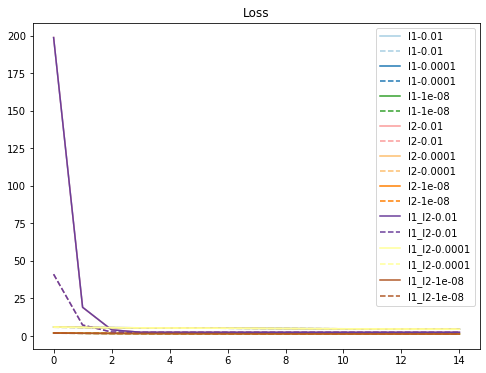

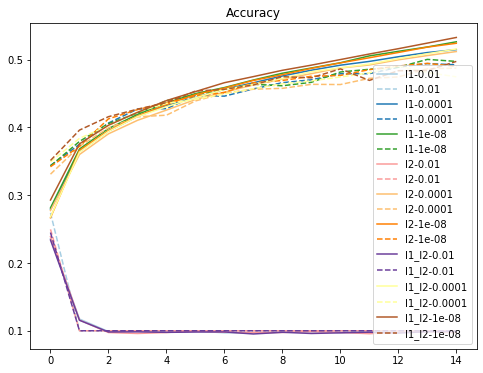

In [14]:
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
# color_bar = ["r", "g", "b", "y", "m", "k"]

NUM_COLORS = len(results.keys())

cm = plt.get_cmap('Paired') #gist_rainbow
#https://www.osgeo.cn/matplotlib/tutorials/colors/colormaps.html
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]


plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()